# Product Injury
<font size=4>Data Prep and Load - Injuries</font>   
***  

**Project Summary:**   
The Consumer Product Safety Commission operations a surveillance system (NEISS) to track injury data related to consumer products. The data is collected from a representative sample of emergency rooms in the United Status. 
This project will examine the data from 2013 through 2022 to explore trends in product injuries resulting in emergency room visits.

**Notebook Scope:**  
This notebook includes code to validate and merge annual injury data. This data has been downloaded from the [NEISS website](https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx).

**Output:**  
The resulting data will be loaded to a SQL Azure database for EDA and Trend Analysis.
***  

***
# Notebook Setup
***

In [1]:
# Import libraries
import pandas as pd

In [2]:
%%html
<!-- Prevent text wrappping in dataframe displays for a cleaner print -->
<style> .dataframe td {white-space: nowrap;}</style>

***  
# Load Injury Data
***

In [3]:
# Read in the NEIS injury data from ean annual Excel file
# NOTE: This code block takes 10-15 minutes to execute
path = '../Data/'
yrs = [x for x in range(2013, 2023)]
rows_read = 0
injuries_df = pd.DataFrame()

for yr in yrs:
    file_name = 'neiss' + str(yr) + '.xlsx'
    sheet_name = 'NEISS' + '_' + str(yr)
    raw_df = pd.read_excel(path + file_name, sheet_name = sheet_name)
    rows_read += len(raw_df)
    injuries_df = pd.concat([injuries_df, raw_df])

In [4]:
# Verify that the length of the combined dataset is the same as the total number of rows read in from all Excel files
print(f'Total rows read:           {rows_read}')
print(f'Rows in combined dataset:  {len(injuries_df)}')

Total rows read:           3559186
Rows in combined dataset:  3559186


In [5]:
# Reset index
injuries_df.reset_index(drop=True, inplace=True)

***
# Preview Data
***

In [6]:
injuries_df.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,...,Product_1,Product_2,Product_3,Alcohol,Drug,Narrative,Stratum,PSU,Weight,Narrative_1
0,130104962,2013-01-01,57,1,1,NaN,NaN,76,53,NaN,...,3299,0,0,NaN,NaN,57YOM FELL WHILE JOGGING ON TRAIL DX: CONTUSIO...,M,100,88.4147,NaN
1,130104963,2013-01-01,207,2,4,NaN,NaN,75,62,NaN,...,1807,0,0,NaN,NaN,7MOF HIT HEAD ON FLOOR AT DAY-CARE DX: CLOSED ...,M,100,88.4147,NaN
2,130104966,2013-01-01,59,2,1,NaN,NaN,79,53,NaN,...,1842,0,0,NaN,NaN,59YOF FELL WHILE ON STAIRS DX: CONTUSION TO BU...,M,100,88.4147,NaN
3,130104968,2013-01-01,17,2,1,NaN,NaN,37,64,NaN,...,4076,0,0,NaN,NaN,17YOF TWISTED ANKLE STEPPING OUT OF BED DX: AN...,M,100,88.4147,NaN
4,130104970,2013-01-01,38,1,1,NaN,NaN,92,59,NaN,...,474,0,0,NaN,NaN,38YOM CUT FINGER ON BROKEN DISH DX: FINGER LAC...,M,100,88.4147,NaN


In [7]:
# Drop rows and columns that consist only of NaN data
injuries_df.dropna(axis = 0, how = 'all', inplace=True)
injuries_df.dropna(axis = 1, how = 'all', inplace=True)

In [8]:
# View shape of the dataframe
injuries_df.shape

(3559186, 26)

***
# Memory Usage
***

In [9]:
# Since our dataset is on the larger size, let's capture the memory usage. This will allow us to evalute how much our cleanup activities
# impact overall size. While this may not be critical in this case, it's a good habit.
print(f'Memory Usage by Column:\n{injuries_df.memory_usage()}')
print(f'\nTotal Memory Usage for Dataframe:   {injuries_df.memory_usage().sum()}')

Memory Usage by Column:
Index                     128
CPSC_Case_Number     28473488
Treatment_Date       28473488
Age                  28473488
Sex                  28473488
Race                 28473488
Other_Race           28473488
Hispanic             28473488
Body_Part            28473488
Diagnosis            28473488
Other_Diagnosis      28473488
Body_Part_2          28473488
Diagnosis_2          28473488
Other_Diagnosis_2    28473488
Disposition          28473488
Location             28473488
Fire_Involvement     28473488
Product_1            28473488
Product_2            28473488
Product_3            28473488
Alcohol              28473488
Drug                 28473488
Narrative            28473488
Stratum              28473488
PSU                  28473488
Weight               28473488
Narrative_1          28473488
dtype: int64

Total Memory Usage for Dataframe:   740310816


***
# Load Data Codes
***

In [10]:
# Read in the scrubbed data codes file. We'll use this later in our data validation activities
file = '../Data/Standard Codes.xlsx'
codes_df = pd.read_excel(file)
codes_df.head()

,Code,Value,Description
0,AGELTTWO,0,UNK
1,AGELTTWO,201,1 MONTH
2,AGELTTWO,202,2 MONTHS
3,AGELTTWO,203,3 MONTHS
4,AGELTTWO,204,4 MONTHS


In [11]:
# Review which data is coded
codes_df['Code'].unique()

array(['AGELTTWO', 'BDYPT', 'DIAG', 'DISP', 'GENDER', 'HISP', 'LOC',
       'PROD', 'RACE'], dtype=object)

***
# Variables
***

In [12]:
# Display variables (column headings) for the dataframe
injuries_df.columns.values

array(['CPSC_Case_Number', 'Treatment_Date', 'Age', 'Sex', 'Race',
       'Other_Race', 'Hispanic', 'Body_Part', 'Diagnosis',
       'Other_Diagnosis', 'Body_Part_2', 'Diagnosis_2',
       'Other_Diagnosis_2', 'Disposition', 'Location', 'Fire_Involvement',
       'Product_1', 'Product_2', 'Product_3', 'Alcohol', 'Drug',
       'Narrative', 'Stratum', 'PSU', 'Weight', 'Narrative_1'],
      dtype=object)

***
**Variable Descriptions**  
-- CPSC_Case_Number: Consumer Product Safety Commision case number  
-- Treatment_Date: date of ER visit  
-- Age: age of patient  
-- Sex: gender of patient  
-- Race: race of patient  
-- Other_Race: description of patient's race if Race is "Other" (code 3)  
-- Hispanic: indicates if the patient is Hispanic  
-- Body_Part: injured body part  
-- Diagnosis: diagnosis of injury  
-- Other_Diagnosis: description if Diagnosis is "Other" (code 71)  
-- Body_Part_2: additional injuried body part  
-- Diagnosis_2: additional diagnosis  
-- Other_Diagnosis_2: description if Other_Diagnosis is "Other" (code 71)  
-- Dipsosition: outcome of the visit  
-- Location: where the injury occurred  
-- Fire_Involvement: indication of whether the injury involved fire  
-- Product_1: primary product involved in the injury  
-- Product_2: additional product involved  
-- Product_3: additional product involved  
-- Alcohol: indicates wheter alcohol was consumed prior to or during the injury  
-- Drug: indicates whether drugs contributed to the injury  
-- Narrative: description of the injury event (used in data files from 2013 - 2019)  
-- Stratum: type of hospital reporting the visit  
-- PSU: primary sampling unit  
-- Weight: statistical weight used for generating national estimates  
-- Narrative_1: description of the injury event (used in data files from 2020 - 2022)  
***

***
## Remove Irrelevant Data
***

In [13]:
# Remove columns that are not needed for our data validation or analysis
cols_to_delete = ['Location', 'Fire_Involvement', 'Alcohol', 'Drug', 'Narrative', 'Narrative_1']
injuries_df.drop(columns=cols_to_delete, inplace=True)

In [14]:
# Reset index
injuries_df.reset_index(drop=True, inplace=True)

***
## Rename Variables for Clarity
***

In [15]:
injuries_df.columns

Index(['CPSC_Case_Number', 'Treatment_Date', 'Age', 'Sex', 'Race',
       'Other_Race', 'Hispanic', 'Body_Part', 'Diagnosis', 'Other_Diagnosis',
       'Body_Part_2', 'Diagnosis_2', 'Other_Diagnosis_2', 'Disposition',
       'Product_1', 'Product_2', 'Product_3', 'Stratum', 'PSU', 'Weight'],
      dtype='object')

In [16]:
# Rename columns
injuries_df.columns = ['Case', 'Date', 'Age', 'Sex', 'Race', 'Other_Race', 'Hispanic', 'Body_Part',
                       'Diagnosis', 'Other_Diagnosis', 'Body_Part_2', 'Diagnosis_2', 'Other_Diagnosis_2',
                       'Disposition', 'Product_1', 'Product_2', 'Product_3', 'Stratum', 'PSU', 'Weight']
injuries_df.head()

,Case,Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,Body_Part_2,Diagnosis_2,Other_Diagnosis_2,Disposition,Product_1,Product_2,Product_3,Stratum,PSU,Weight
0,130104962,2013-01-01,57,1,1,NaN,NaN,76,53,NaN,NaN,NaN,NaN,1,3299,0,0,M,100,88.4147
1,130104963,2013-01-01,207,2,4,NaN,NaN,75,62,NaN,NaN,NaN,NaN,1,1807,0,0,M,100,88.4147
2,130104966,2013-01-01,59,2,1,NaN,NaN,79,53,NaN,NaN,NaN,NaN,1,1842,0,0,M,100,88.4147
3,130104968,2013-01-01,17,2,1,NaN,NaN,37,64,NaN,NaN,NaN,NaN,1,4076,0,0,M,100,88.4147
4,130104970,2013-01-01,38,1,1,NaN,NaN,92,59,NaN,NaN,NaN,NaN,1,474,0,0,M,100,88.4147


***
## Data Types and Format
***

In [17]:
# Review column data types
injuries_df.dtypes

Case                          int64
Date                 datetime64[ns]
Age                           int64
Sex                           int64
Race                          int64
Other_Race                   object
Hispanic                    float64
Body_Part                     int64
Diagnosis                     int64
Other_Diagnosis              object
Body_Part_2                 float64
Diagnosis_2                 float64
Other_Diagnosis_2            object
Disposition                   int64
Product_1                     int64
Product_2                     int64
Product_3                     int64
Stratum                      object
PSU                           int64
Weight                      float64
dtype: object

In [18]:
# Review the range of int64 columns to see if they could be re-types as int32
int_cols = injuries_df.select_dtypes(include=['int']).columns
for col in int_cols:
    print(f'{col:<12} {injuries_df[col].min():>10} to {injuries_df[col].min()}')

Case          130104962 to 130104962
Age                   0 to 0
Sex                   0 to 0
Race                  0 to 0
Body_Part             0 to 0
Diagnosis            41 to 41
Disposition           1 to 1
Product_1           102 to 102
Product_2             0 to 0
Product_3             0 to 0
PSU                   1 to 1


In [19]:
# Convert int64 columns to int32
injuries_df[int_cols] = injuries_df[int_cols].astype('int32')

In [20]:
# Review float columns that should should be ints
float_cols = injuries_df.select_dtypes(include=['float']).columns.to_list()
float_cols.remove('Weight')
for col in float_cols:
    print(f'{col}\n{injuries_df[col].unique()}\n')

Hispanic
[nan  0.  2.  1.]

Body_Part_2
[nan 85. 35. 82. 93. 76. 75. 31. 32. 88. 81. 30. 34. 92. 79. 87. 37. 38.
 89. 94. 83. 36. 80. 33. 77.  0. 84.]

Diagnosis_2
[nan 68. 64. 57. 59. 62. 71. 53. 58. 72. 48. 55. 66. 51. 56. 74. 61. 52.
 63. 60. 50. 46. 54. 42. 67. 41. 65. 49. 47. 73. 69.]



In [21]:
# Since there are no legitimate values assigned to -1, we'll replace nan values with -1 and then convert to int32
injuries_df[float_cols] = injuries_df[float_cols].fillna(-1)
injuries_df[float_cols] = injuries_df[float_cols].astype('int32')

***
# Missing Data
***  

In [26]:
# Look for columns with null values
injuries_df.columns[injuries_df.isnull().any()]

Index(['Other_Race', 'Other_Diagnosis', 'Other_Diagnosis_2'], dtype='object')

***
**Note:**  
We'll keep these columns for now, as we can use them for data integrity checks later on. However, we will delete them prior to EDA. For
our purposes, we will use the predefined Race, Other Diagnosis and Other Diagnosis 2 data and not use write-in values for analysis.  
***

In [32]:
# Look for columns with a -1 value, as we used this indicate missing numeric values
injuries_df.columns[injuries_df.eq(-1).any()]

Index(['Hispanic', 'Body_Part_2', 'Diagnosis_2'], dtype='object')

In [33]:
# All three columms were added in 2019, so the data available is limited. For consistency, we will not consider these columns 
# in our analysis
injuries_df.drop(columns=['Hispanic', 'Body_Part_2', 'Diagnosis_2'], inplace=True)

***
# Duplicate Records
***

In [52]:
# Check for duplicated case numbers
# Look for duplicate code/value combinations that have different descriptions
injuries_df[injuries_df.duplicated(subset='Case')]

,Case,Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Other_Diagnosis_2,Disposition,Product_1,Product_2,Product_3,Stratum,PSU,Weight


***
# Data Review and Cleanup
***

## Date
***

In [58]:
# Verify all dates are within our date range
print(f'Start Date:   {injuries_df["Date"].min().strftime("%b %d, %Y")}')
print(f'End Date:     {injuries_df["Date"].max().strftime("%b %d, %Y")}')

Start Date:   Jan 01, 2013
End Date:     Dec 31, 2022


<AxesSubplot: >

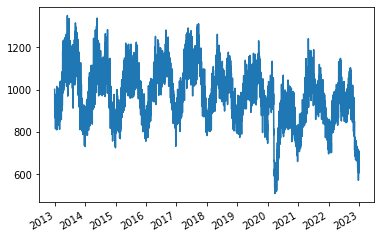

In [60]:
# Review distribution of dates
injuries_df['Date'].value_counts().plot()

<AxesSubplot: >

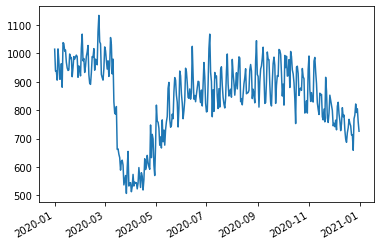

In [63]:
# Let's take a closer look at the date distributions for 2020 and 2022
inj_2020_df = injuries_df[injuries_df['Date'].dt.year == 2020].copy()
inj_2020_df['Date'].value_counts().plot()

<AxesSubplot: >

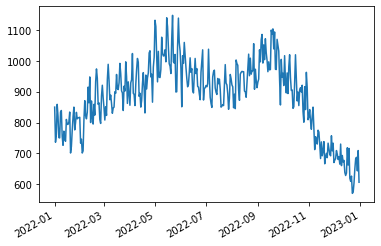

In [64]:
inj_2022_df = injuries_df[injuries_df['Date'].dt.year == 2022].copy()
inj_2022_df['Date'].value_counts().plot()

***  
**Note:**  
Further investigation is required to see why there are much lower injury reports in early 2020 and late 2022
***

## Age
***

In [71]:
injuries_df['Stratum'].unique()

array(['M', 'S', 'V', 'L', 'C'], dtype=object)

<AxesSubplot: ylabel='Frequency'>

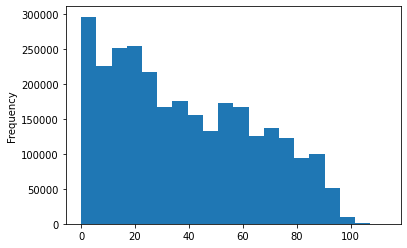

In [73]:
# Review age distribution
injuries_df[injuries_df['Stratum'] != 'C']['Age'].plot.hist(bins=20)

In [65]:
# Check for missing or unknown age, which is coded as 0
print(f'Unknown Age:  {len(injuries_df[injuries_df["Age"] == 0])}')

Unknown Age:  280


In [66]:
# Given the small number of rows with unknown age, we will simply remove these rows from the dataset
rows_to_drop = injuries_df[injuries_df['Age'] == 0].index.to_list()
injuries_df.drop(index=rows_to_drop, inplace=True)

In [67]:
# Review age value ranges
print(f'Min Age:   {injuries_df["Age"].min()}')
print(f'Max Age:   {injuries_df["Age"].max()}')

Min Age:   2
Max Age:   223


In [68]:
# From the documentation provided by NEISS, ages less than 2 are coded by month.
codes_df[codes_df['Code'] == 'AGELTTWO']

,Code,Value,Description
0,AGELTTWO,0,UNK
1,AGELTTWO,201,1 MONTH
2,AGELTTWO,202,2 MONTHS
3,AGELTTWO,203,3 MONTHS
4,AGELTTWO,204,4 MONTHS
5,AGELTTWO,205,5 MONTHS
6,AGELTTWO,206,6 MONTHS
7,AGELTTWO,207,7 MONTHS
8,AGELTTWO,208,8 MONTHS
9,AGELTTWO,209,9 MONTHS


In [69]:
# For our purposes, we only want to consider age by year. Ages 1 Month to 11 Months will be relabeled as 0 years old
# and ages 12 Months to 23 months will be relabled a 1 year old
injuries_df.loc[injuries_df['Age'].between(200, 211), 'Age'] = 0
injuries_df.loc[injuries_df['Age'].between(212, 223), 'Age'] = 1

<AxesSubplot: ylabel='Frequency'>

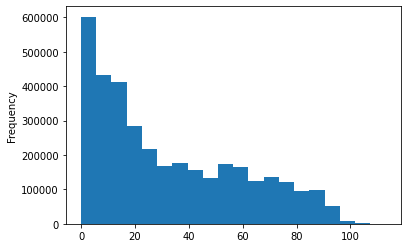

In [70]:
# Review age distribution
injuries_df['Age'].plot.hist(bins=20)

***
<font color='red'>**Note:**</font>  
More investigation needed. This distribution doesn't look like the distribution of age in the general population.   
Is that expected?  Do I need to consider PSU and weight? (Are children's hospitals disproportially represented?)
***

# 

***
# Review Data Set
***

In [ ]:
# Review the columns
injuries_df.columns

In [ ]:
# Delete columns that are not tied to our project objectives
cols_to_drop = ['Fire_Involvement', 'Alcohol', 'Drug', 'Narrative', 'Narrative_1']
injuries_df.drop(columns=cols_to_drop, inplace=True)

***
# Case Number
***

In [ ]:
# Verify that all rows have a unique case number
print(f'Number of rows:       {len(injuries_df)}')
print(f'Unique Case Numbers:  {len(injuries_df["CPSC_Case_Number"].unique())}')

In [ ]:
# Check datatype is set correctly
injuries_df['CPSC_Case_Number'].dtype

In [ ]:
# Rename column and set as index, downcasting as an int32
injuries_df.rename(columns={'CPSC_Case_Number': 'Case'}, inplace=True)
injuries_df.set_index('Case', drop=True, inplace=True)

In [ ]:
# Preview dataframe with changes
injuries_df.head()

***  
# Treatment Date
***  

In [ ]:
# Check data type
injuries_df['Treatment_Date'].dtypes

In [ ]:
# Check for missing values
print(f'Missing Treatment Dates:   {len(injuries_df[injuries_df["Treatment_Date"].isnull()])}')

In [ ]:
# Check for outliers - ourdata range should be from Jan 1, 2013 to Dec 31, 2022
print(f'Start Date:   {injuries_df["Treatment_Date"].min().strftime("%b %d, %Y")}')
print(f'End Date:     {injuries_df["Treatment_Date"].max().strftime("%b %d, %Y")}')

In [ ]:
# Review distribution of dates
injuries_df['Treatment_Date'].value_counts().plot()

In [ ]:
# Let's take a closer look at the date distributions for 2020 and 2022
inj_2020_df = injuries_df[injuries_df['Treatment_Date'].dt.year == 2020].copy()
inj_2020_df['Treatment_Date'].value_counts().plot()

In [ ]:
inj_2022_df = injuries_df[injuries_df['Treatment_Date'].dt.year == 2022].copy()
inj_2022_df['Treatment_Date'].value_counts().plot()

***  
<font color='red'>**Note:**</font>  
Further investigation required on why 2020 and 2022 much lower injury reports
***

***  
# Age
***  

In [ ]:
# Check datatype
injuries_df['Age'].dtypes

In [ ]:
# Check for missing or unknown age. (Unknown age is currently coded as 0.)
print(f'Null Age:     {len(injuries_df[injuries_df["Age"].isnull()])}')
print(f'Unknown Age:  {len(injuries_df[injuries_df["Age"] == 0])}')

In [ ]:
# Given the small number of rows with unknown age, we will simply remove these rows from the dataset
rows_to_drop = injuries_df[injuries_df['Age'] == 0].index.to_list()
injuries_df.drop(index=rows_to_drop, inplace=True)

In [ ]:
# Review age value ranges
print(f'Min Age:   {injuries_df["Age"].min()}')
print(f'Max Age:   {injuries_df["Age"].max()}')

In [ ]:
# From the documentation provided by NEISS, ages less than 2 are coded by month.
codes_df[codes_df['Code'] == 'AGELTTWO']

In [ ]:
# For our purposes, we only want to consider age by year. Ages 1 Month to 11 Months will be relabeled as 0 years old
# and ages 12 Months to 23 months will be relabled a 1 year old
injuries_df.loc[injuries_df['Age'].between(200, 211), 'Age'] = 0
injuries_df.loc[injuries_df['Age'].between(212, 223), 'Age'] = 1

In [ ]:
# Review age distribution
injuries_df['Age'].plot.hist(bins=20)

In [ ]:
# Downcast age
injuries_df['Age'] = injuries_df['Age'].astype(int)

***
<font color='red'>**Note:**</font>  
More investigation needed. This distribution doesn't look like the distribution of age in the general population.   
Is that expected?  Do I need to consider PSU and weight?
***

***
# Gender
***

In [ ]:
# Check datatype
injuries_df['Sex'].dtypes

In [ ]:
# Check for missing or unknown sex. (Unknown sex is currently coded as 0.)
print(f'Null Sex:     {len(injuries_df[injuries_df["Sex"].isnull()])}')
print(f'Unknown Sex:  {len(injuries_df[injuries_df["Sex"] == 0])}')

In [ ]:
# Review codes
codes_df[codes_df['Code'] == 'GENDER']

In [ ]:
# Check for Gender data that doesn't match up with a Gender code
missing = False
codes = codes_df[codes_df['Code'] == 'GENDER']['Value'].values
for i in injuries_df['Sex'].unique():
    if i not in codes:
        print(f'{i} code is used in Injuries data is missing from the code file.')
        missing = True
if missing == False:
    print('All codes used in the Injuries dataset are valid.')

***
<font color='red'>**Note:**</font>  
What to do with unknowns?
***

In [ ]:
# Downcast Sex
injuries_df['Sex'] = injuries_df['Sex'].astype(int)

***  
# Race, Other Race, Hispanic
***  

In [ ]:
# Review data types
injuries_df[['Race', 'Other_Race', 'Hispanic']].dtypes

In [ ]:
# Review Race and Hispanic codes
codes_df[codes_df['Code'].isin(['RACE', 'HISP'])]

In [ ]:
# Check for missing or unknown Race
print(f'Null Race:     {len(injuries_df[injuries_df["Race"].isnull()])}')
print(f'Unknown Race:  {len(injuries_df[injuries_df["Race"] == 0])}')

In [ ]:
# Unknown Race as a percent of all records
total_rows = len(injuries_df)
print(f'Percent of records with Unknown Race:  {round((len(injuries_df[injuries_df["Race"] == 0])/total_rows)*100, 2)}%')

In [ ]:
# Check for Race data that doesn't match up with a Race code
missing = False
codes = codes_df[codes_df['Code'] == 'RACE']['Value'].values
for i in injuries_df['Race'].unique():
    if i not in codes:
        print(f'{i} code is used in Injuries data is missing from the code file.')
        missing = True
if missing == False:
    print('All codes used in the Injuries dataset are valid.')

***  
<font color='red'>**Note:**</font>  
What to do with Race data?  
Delete? Impute using mean, median, or mode? Or use an algorithm like random forest?
  
If keeping, downcast to int8?
***  

In [ ]:
# Check for NaN data in Other Race
print(f'NaN Other Race:   {len(injuries_df[injuries_df["Other_Race"].isna()])}')

In [ ]:
# Missing Other Race as a percent of all records
print(f'Percent of records with Unknown Race:  {round((len(injuries_df[injuries_df["Other_Race"].isna()])/total_rows)*100, 2)}%')

In [ ]:
# Given the large amount of data missing in the Other Race column, we will not use this data in our analysis
injuries_df.drop(columns=['Other_Race'], inplace=True)

In [ ]:
# Check for missing or unknown Hispanic data
print(f'Null Hispanic:     {len(injuries_df[injuries_df["Hispanic"].isnull()])}')
print(f'Unknown Hispanic:  {len(injuries_df[injuries_df["Hispanic"] == 0])}')

In [ ]:
# Missing or Null Hispanic data as a percent of all records
miss_nan = len(injuries_df[injuries_df["Hispanic"].isnull()]) + len(injuries_df[injuries_df["Hispanic"] == 0])
print(f'Percent of records with Unknown or Missing Hispanic:  {round((miss_nan/total_rows)*100, 2)}%')

In [ ]:
# Given the large amount of data missing in the Hispanic column, we will not use this data in our analysis
injuries_df.drop(columns=['Hispanic'], inplace=True)

***  
# Body Part
***

In [ ]:
# Review data types
injuries_df[['Body_Part', 'Body_Part_2']].dtypes

In [ ]:
# Review Body Part Codes
codes_df[codes_df['Code'] == 'BDYPT']

In [ ]:
# Check for missing or unknown body parts
print(f'Null Body Part:     {len(injuries_df[injuries_df["Body_Part"].isnull()])}')
print(f'Unknown Body Part:  {len(injuries_df[injuries_df["Body_Part"] == 87])}')

In [ ]:
# Records with an unknown body part as a percent of all records
print(f'Percent of records with Unknown Body Part:  {round((len(injuries_df[injuries_df["Body_Part"] == 87])/total_rows)*100, 2)}%')

In [ ]:
# Check for Body Part data that doesn't match up with a Body Part code
missing = False
codes = codes_df[codes_df['Code'] == 'BDYPT']['Value'].values
for i in injuries_df['Body_Part'].unique():
    if i not in codes:
        print(f'{i} code is used in Injuries data is missing from the code file.')
        missing = True
if missing == False:
    print('All codes used in the Injuries dataset are valid.')

***
<font color='red'>**Note:**</font>  
What to do with the unknown body part data?  
Delete? Impute? Do Nothing?
***

In [ ]:
# Downcast Body Part
injuries_df['Body_Part'] = injuries_df['Body_Part'].astype(int)

In [ ]:
# Records with missing Body_Part_2 data
print(f'Missing Body Part 2:   {len(injuries_df[injuries_df["Body_Part_2"].isna()])}')

In [ ]:
# Records with missing Body_Part_2 as a percent of the whole
print(f'Percent of records with Unknown Body Part:  {round((len(injuries_df[injuries_df["Body_Part_2"].isna()])/total_rows)*100, 2)}%')

In [ ]:
# Given the significant amount of missing data, let's delete this column
injuries_df.drop(columns='Body_Part_2', inplace=True)

*** 
# Diagnosis
***

In [ ]:
# Check data types
injuries_df[['Diagnosis', 'Diagnosis_2', 'Other_Diagnosis', 'Other_Diagnosis_2']].dtypes

In [ ]:
# Review missing data
print(f'Null Diagnosis:     {len(injuries_df[injuries_df["Diagnosis"].isnull()])}')
print(f'Null Diagnosis 2:   {len(injuries_df[injuries_df["Diagnosis_2"].isnull()])}')

In [ ]:
# Given the significant amount of missing data, let's delete this column
injuries_df.drop(columns='Diagnosis_2', inplace=True)

In [ ]:
# Review Diagnosis Codes
codes_df[codes_df['Code'] == 'DIAG']

In [ ]:
# Check for Diagnosis data that doesn't match up with a Diagnosis code
missing = False
codes = codes_df[codes_df['Code'] == 'DIAG']['Value'].values
for i in injuries_df['Diagnosis'].unique():
    if i not in codes:
        print(f'{i} code is used in Injuries data is missing from the code file.')
        missing = True
if missing == False:
    print('All codes used in the Injuries dataset are valid.')

In [ ]:
# Downcast Diagnosis column
injuries_df['Diagnosis'] = injuries_df['Diagnosis'].astype(int)

In [ ]:
# Review missing data
print(f'Null Other Diagnosis:     {len(injuries_df[injuries_df["Other_Diagnosis"].isna()])}')
print(f'Null Other Diagnosis 2:   {len(injuries_df[injuries_df["Other_Diagnosis_2"].isna()])}')

In [ ]:
# Records with missing Body_Part_2 as a percent of the whole
print(f'Percent of records with Missing Other Diagnosis:    {round((len(injuries_df[injuries_df["Other_Diagnosis"].isna()])/total_rows)*100, 2)}%')
print(f'Percent of records with Missing Other Diagnosis 2:  {round((len(injuries_df[injuries_df["Other_Diagnosis_2"].isna()])/total_rows)*100, 2)}%')

In [ ]:
# Drop Other Diagnosis and Other Diagnosis 2 columns
injuries_df.drop(columns=['Other_Diagnosis', 'Other_Diagnosis_2'], inplace=True)

***
# Disposition
***

In [ ]:
# Check data type
injuries_df['Disposition'].dtypes

In [ ]:
# Review Disposition codes
codes_df[codes_df['Code'] == 'DISP']

In [ ]:
# Review missing data
print(f'Null Disposition:     {len(injuries_df[injuries_df["Disposition"].isnull()])}')
print(f'Unknown Disposition:  {len(injuries_df[injuries_df["Disposition"] == 9])}')

In [ ]:
# Check for Diagnosis data that doesn't match up with a Diagnosis code
missing = False
codes = codes_df[codes_df['Code'] == 'DISP']['Value'].values
for i in injuries_df['Disposition'].unique():
    if i not in codes:
        print(f'{i} code is used in Injuries data is missing from the code file.')
        missing = True
if missing == False:
    print('All codes used in the Injuries dataset are valid.')

In [ ]:
# Downcast Disposition
injuries_df['Disposition'] = injuries_df['Disposition'].astype(int)

***
# Location
***

In [ ]:
# Check data type
injuries_df['Location'].dtypes

In [ ]:
# Review the location codes
codes_df[codes_df['Code'] == 'LOC']

In [ ]:
# Review missing data
print(f'Null Location:     {len(injuries_df[injuries_df["Location"].isnull()])}')
print(f'Unknown Location:  {len(injuries_df[injuries_df["Location"] == 0])}')

In [ ]:
# Records with unknown Location as a percent of the whole
print(f'Percent of records with unknown Location:    {round((len(injuries_df[injuries_df["Location"] == 0])/total_rows)*100, 2)}%')

***
<font color='red'>**Note:**</font>  
What to do with the unknown location data?  
Delete? Impute? Do Nothing?
***

In [ ]:
# Check for Location data that doesn't match up with a Diagnosis code
missing = False
codes = codes_df[codes_df['Code'] == 'LOC']['Value'].values
for i in injuries_df['Location'].unique():
    if i not in codes:
        print(f'{i} code is used in Injuries data is missing from the code file.')
        missing = True
if missing == False:
    print('All codes used in the Injuries dataset are valid.')

In [ ]:
# Downcast location
injuries_df['Location'] = injuries_df['Location'].astype(int)

***
# Products
***

In [ ]:
# Check data types
injuries_df[['Product_1', 'Product_2', 'Product_3']].dtypes

In [ ]:
# Review product codes
codes_df[codes_df['Code'] == 'PROD']

In [ ]:
# Review missing data
print(f'Null Product 1:      {len(injuries_df[injuries_df["Product_1"].isnull()])}')
print(f'Null Product 2:      {len(injuries_df[injuries_df["Product_2"].isnull()])}')
print(f'Null Product 3:      {len(injuries_df[injuries_df["Product_3"].isnull()])}')
print(f'Missing Product 1:   {len(injuries_df[injuries_df["Product_1"] == 0])}')
print(f'Missing Product 2:   {len(injuries_df[injuries_df["Product_2"] == 0])}')
print(f'Missing Product 3:   {len(injuries_df[injuries_df["Product_3"] == 0])}')

In [ ]:
# Records with missing product as a percent of the whole
print(f'Percent of records with missing Product 2:    {round((len(injuries_df[injuries_df["Product_2"] == 0])/total_rows)*100, 2)}%')
print(f'Percent of records with missing Product 3:    {round((len(injuries_df[injuries_df["Product_3"] == 0])/total_rows)*100, 2)}%')

In [ ]:
# Drop Product 2 and Product 3 columns due to limited to data
injuries_df.drop(columns=['Product_2', 'Product_3'], inplace=True)

In [ ]:
# Check for Product data that doesn't match up with a Product code
missing = False
codes = codes_df[codes_df['Code'] == 'PROD']['Value'].values
for i in injuries_df['Product_1'].unique():
    if i not in codes:
        print(f'{i} code is used in Injuries data is missing from the code file.')
        missing = True
if missing == False:
    print('All codes used in the Injuries dataset are valid.')

In [ ]:
# Downcast Product 1
injuries_df['Product_1'] = injuries_df['Product_1'].astype(int)

***
# Stratum
***

In [ ]:
# Check datatype
injuries_df['Stratum'].dtypes

In [ ]:
# Check for Missing or Null values
print(f'Null Stratum:     {len(injuries_df[injuries_df["Stratum"].isnull()])}')
print(f'Empty Stratum:    {len(injuries_df[injuries_df["Stratum"] == ""])}')

In [ ]:
print(injuries_df['Stratum'].value_counts())
print(f'\nTotal: {injuries_df["Stratum"].value_counts().sum()}')

***
# PSU, Weight
***

***
# Memory Usage
***

In [ ]:
# Since our dataset is on the larger size, let's capture the memory usage. This will allow us to evalute how much our cleanup activities
# impact overall size. While this may not be critical in this case, it's a good habit.
print(f'Memory Usage by Column:\n{injuries_df.memory_usage()}')
print(f'\nTotal Memory Usage for Dataframe:   {injuries_df.memory_usage().sum()}')

In [ ]:
# Check for missing or null values
print(f'Empty Stratum:     {len(injuries_df[injuries_df["Stratum"] == ""])}')